In [1]:
import random
import numpy as np
import pandas as pd
import shap

from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

SEED = 13
seed_everything(SEED)

# Loading Data

In [3]:
df_train = pd.read_csv('data/train.csv') # index_col='date'
df_test = pd.read_csv('data/test.csv') # index_col='date'

df_train['date'] = pd.to_datetime(df_train.date)
df_test['date'] = pd.to_datetime(df_test.date)

# Time Series Cross Validation

In [4]:
def performTimeSeriesCV(df_train, target, number_folds, model, metric, preprocessor=None, kwargs={}):
    dates = df_train.date.unique()
    k = len(dates) // number_folds

    metrics = []
 
    for i in range(1, number_folds):
        train_index = dates[:(k * i)]
        
        if i == number_folds - 1:
            val_index = dates[(k * i):]
        else:
            val_index = dates[(k * i):(k * (i + 1))]
        
        train = df_train[df_train.date.isin(train_index)]
        val = df_train[df_train.date.isin(val_index)]
       
        X_train = train.drop(columns=['date', 'target_revenue', 'target_income'])     
        y_train = train[target]

        X_val = val.drop(columns=['date', 'target_revenue', 'target_income'])     
        y_val = val[target]
        
        if preprocessor:
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)
            model.fit(X_train, y_train, **kwargs)
        else:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
        
        metrics.append(metric(y_val, model.predict(X_val),))
   
    return metrics

In [5]:
def SMAPE(y_true, y_pred):
    return (100 / y_true.size) * np.sum(2 * np.abs(y_pred - y_true) / (abs(y_true) + abs(y_pred)))

# Baseline

У нас в задаче две целевые переменные: revenue и income. Однако из-за того, что у них очень высокая корреляция, чтобы не дублировать весь код пока будем прогнозировать только Revenue. Когда определим оптимальную модель для revenue (оптимальные признаки и оптимальные гиперпараметры), то просто обучим такую же модель для income.

## Linear Regression

В качестве бейзлайн модели построим линейную регрессию.

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_features = ['Revenue', 'Operating Income', 'Pretax Income', 
                'Income (Loss) from Cont Ops', 'Net Income', 'Net Income Avail to Common',
                'Total Equity', 'Cash from Operations',
                'Cash from Investing Activities', 'Cash from Financing Activities']
cat_features = ['Company']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)])

linear_regression = LinearRegression()

In [7]:
smape_baseline_cv = performTimeSeriesCV(df_train, 'target_revenue', 3,
                                        linear_regression, SMAPE, preprocessor)

In [8]:
print(f'Mean SMAPE of base model on cross validation: {round(np.mean(smape_baseline_cv), 4)}')

Mean SMAPE of base model on cross validation: 44.6489


In [9]:
X_test = df_test.drop(columns=['date', 'target_revenue', 'target_income'])     
y_test = df_test['target_revenue']

smape_baseline_test = SMAPE(y_test, linear_regression.predict(preprocessor.transform(X_test)))

print(f'Mean SMAPE of base model on test: {round(np.mean(smape_baseline_test), 4)}')

Mean SMAPE of base model on test: 43.4163


## Ridge Regression

Попробуем добавить регуляризацию в нашу модель. Коэффициент регуляризация будем подбирать.

In [10]:
grid_results = {}
optim_smape = 1000

for alpha in tqdm(np.linspace(0.01, 3, 300)):
    ridge_regression = Ridge(alpha=alpha)
    smape = np.mean(performTimeSeriesCV(df_train, 'target_revenue', 3,
                                        ridge_regression, SMAPE, preprocessor))
    
    grid_results[smape] = alpha
    if smape < optim_smape:
        optim_smape = smape

optim_smape, grid_results[optim_smape]

  0%|          | 0/300 [00:00<?, ?it/s]

(34.7192623758507, 2.26)

In [11]:
ridge_regression = Ridge(alpha=grid_results[optim_smape])

smape_ridge_cv = performTimeSeriesCV(df_train, 'target_revenue', 3,
                                     ridge_regression, SMAPE, preprocessor)

print(f'Mean SMAPE of Ridge Regression (alpha={grid_results[optim_smape]}) on cross validation: '
      f'{round(np.mean(smape_ridge_cv), 4)}')

Mean SMAPE of Ridge Regression (alpha=2.26) on cross validation: 34.7193


In [12]:
smape_ridge_test = SMAPE(y_test, ridge_regression.predict(preprocessor.transform(X_test)))

print(f'Mean SMAPE of base model on test: {round(np.mean(smape_ridge_test), 4)}')

Mean SMAPE of base model on test: 34.9807


Как можно увидеть выше, с помощью регуляризации удалось существенно улучшить качество модели.

## Coefficients Interpretation

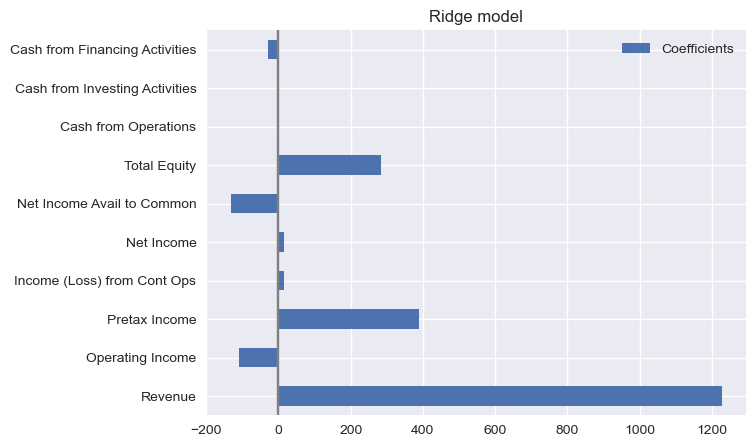

In [13]:
coefs = pd.DataFrame(
    ridge_regression.coef_[:10],
    columns=['Coefficients'],
    index=num_features
)

coefs.plot(kind='barh', figsize=(9, 5))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Наибольшее влияние оказывает признак Revenue, который отражает вырочку в прошлом квартале. А так как мы прдесказываем Revenue, то этот результат выглядит весьма логичным.

# CatBoost

Попробуем улучшить бейзлан, используя CatBoost. Для начала обучим данную модель с гиперпамраметрами по умолчанию.

In [14]:
cat_features = ['Company']
for cat_feature in cat_features:
    df_train[cat_features] = df_train[cat_features].astype('category')

In [15]:
CBr = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features,
                        random_seed=SEED, verbose=False)

smape_cbr_cv = performTimeSeriesCV(df_train, 'target_revenue', 3, CBr, SMAPE)

In [16]:
print(f'Mean SMAPE of base model on cross validation: {round(np.mean(smape_cbr_cv), 4)}')

Mean SMAPE of base model on cross validation: 59.5057


In [17]:
for cat_feature in cat_features:
    df_test[cat_features] = df_test[cat_features].astype('category')
    
X_test = df_test.drop(columns=['date', 'target_revenue', 'target_income'])     
y_test = df_test['target_revenue']

In [18]:
smape_cbr_test = SMAPE(y_test, CBr.predict(X_test))

print(f'Mean SMAPE of base model on test: {round(np.mean(smape_cbr_test), 4)}')

Mean SMAPE of base model on test: 59.8275


Итоговое качество CatBoost на изначальных признаках с гиперпараметрами по умолчанию следующее
- *SMAPE по CV с 3 фолдами:* **59.5057**
- *SMAPE на тесте:* **59.8275**

Данные результаты существенно хуже бейзлана, поэтому продолжим улучшать CatBoost.

# Improving baseline model

## Additional Features Generation

Для начала сгенерируем два календарных категориальных признака: квартал и год. Создание дополнительных календарных признаков кажется здесь лишним.

In [19]:
df_train['quarter'] = df_train.date.dt.quarter
df_train['year'] = df_train.date.dt.year

df_test['quarter'] = df_test.date.dt.quarter
df_test['year'] = df_test.date.dt.year

In [20]:
cat_features.extend(['quarter', 'year'])

for cat_feature in cat_features:
    df_train[cat_features] = df_train[cat_features].astype('category')
    df_test[cat_features] = df_test[cat_features].astype('category')

Создадим функцию по генерации дополнительных количественных признаков

In [21]:
def percentile(n):
    """Calculate n - percentile of data"""

    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = "pctl%s" % n
    return percentile_


def generate_features(
    df,
    target_var,
    all_id_columns=['date', 'Company'],
    org_id_columns=["Company"],
    windows=[4, 8],
    aggregation_methods={"mean", "median", "max", "min"}, # percentile(10), percentile(90)
):
    out_df = df.copy(deep=True)
    for w in tqdm(windows):
        lf_df = (
            df
            .set_index(all_id_columns)[target_var]
            .groupby(level=org_id_columns)
            .apply(
                lambda x: x.rolling(window=w, min_periods=1).agg(
                    aggregation_methods
                )
            )
        )
        
        lf_df.columns = lf_df.columns.to_flat_index()
        new_names = {x: "wdw{0}_{1}_{2}".format(w, x[0], x[1]) for x in lf_df.columns}
        lf_df = lf_df.reset_index().rename(columns=new_names)
        
        out_df = pd.merge(
            out_df, lf_df, how="left", on=all_id_columns
        )


    return out_df

In [22]:
quant_features = ['Revenue', 'Operating Income', 'Total Equity', 'Cash from Operations',
                  'Cash from Investing Activities', 'Cash from Financing Activities']

df = pd.concat([df_train, df_test], axis=0).sort_values(by=['Company', 'date'])
df_features = generate_features(df, quant_features).sort_values(by=['Company', 'date'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
dates = sorted(df.date.unique())

df_train_features = df_features[df_features.date.isin(dates[:37])]
df_test_features = df_features[df_features.date.isin(dates[37:41])]

Обучим модель с новыми сгенерированными признаками

In [24]:
CBr_features = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features,
                                 random_seed=SEED, verbose=False)

smape_features_cv = performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_features, SMAPE)

In [25]:
print(f'Mean SMAPE of model with additional features on cross validation: {round(np.mean(smape_features_cv), 4)}')

Mean SMAPE of model with additional features on cross validation: 48.8463


In [26]:
X_test_features = df_test_features.drop(columns=['date', 'target_revenue', 'target_income'])     
y_test_features = df_test_features['target_revenue']

In [27]:
smape_features_test = SMAPE(y_test_features, CBr_features.predict(X_test_features))

print(f'Mean SMAPE of model with additional features on test: {round(np.mean(smape_features_test), 4)}')

Mean SMAPE of model with additional features on test: 50.8182


Итоговое качество модели со сгенерированными признаками с гиперпараметрами по умолчанию следующее
- *SMAPE по CV с 3 фолдами:* **48.8463**
- *SMAPE на тесте:* **50.8182**

Как можно увидеть, удалось добиться существенного прироста в качестве по сравнению с предыдущей моделью, однако это всё ещё ниже бейзлайн модели.

## Searching for Optimal Hyperparameters

Подбор параметров я осуществляю не просто чрез grid search, а по следующей схеме:
1. Выбираем относительно большой lr [0.05, 0.3], подбираем оптимальное кол-во деревьев для выбранного lr.
2. Настраиваем параметры, начиная с самых значимых (depth, l2_leaf_reg).
3. Уменьшаем lr, пропорционально увеличиваем число деревьев.

Внизу продемонстрирована уже последняя итерация подбора.

In [28]:
cat_dict = {'learning_rate': [0.15, 0.075, 0.05, 0.015],
            'iterations': [100, 150, 200, 300, 1000]}

grid = ParameterGrid(cat_dict)
grid_results = {}
optim_smape = 1000

for params in tqdm(grid):
    CBr_grid = CatBoostRegressor(loss_function='MAPE', depth=10, l2_leaf_reg=2,
                                 random_strength=1, cat_features=cat_features,
                                 random_seed=SEED, verbose=False, **params)
    
    smape = np.mean(performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_grid, SMAPE))
    
    grid_results[smape] = params
    print(smape, params)
    if smape < optim_smape:
        optim_smape = smape

optim_smape, grid_results[optim_smape]

  0%|          | 0/20 [00:00<?, ?it/s]

52.06193188615967 {'iterations': 100, 'learning_rate': 0.15}
41.89616834481858 {'iterations': 100, 'learning_rate': 0.075}
42.16826525093849 {'iterations': 100, 'learning_rate': 0.05}
59.2460257373415 {'iterations': 100, 'learning_rate': 0.015}
51.89684643303838 {'iterations': 150, 'learning_rate': 0.15}
41.237239558155785 {'iterations': 150, 'learning_rate': 0.075}
40.70660810796869 {'iterations': 150, 'learning_rate': 0.05}
50.26682978186605 {'iterations': 150, 'learning_rate': 0.015}
39.987057182924886 {'iterations': 200, 'learning_rate': 0.15}
42.16762369176797 {'iterations': 200, 'learning_rate': 0.075}
40.053397015128276 {'iterations': 200, 'learning_rate': 0.05}
42.31985489638778 {'iterations': 200, 'learning_rate': 0.015}
39.987057182924886 {'iterations': 300, 'learning_rate': 0.15}
42.16762369176797 {'iterations': 300, 'learning_rate': 0.075}
40.053397015128276 {'iterations': 300, 'learning_rate': 0.05}
39.77885070605585 {'iterations': 300, 'learning_rate': 0.015}
39.987057182

(37.36625812124828, {'iterations': 1000, 'learning_rate': 0.015})

Итоговые оптимальные гиперпараметры следующие:
- learning_rate: 0.015
- iterations: 1000
- depth: 10
- l2_leaf_reg: 2
- random_strength: 1

Посмотрим на качество полученной модели

In [29]:
opt_hyperparams = {
    'learning_rate': 0.015,
    'iterations': 1000,
    'depth': 10,
    'l2_leaf_reg': 2,
    'random_strength': 1
}

In [30]:
CBr_features_opt = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features,
                                     random_seed=SEED, verbose=False, **opt_hyperparams)

smape_features_opt_cv = performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_features_opt, SMAPE)

In [31]:
print(f'Mean SMAPE of optimal model with additional features on cross validation: ' 
      f'{round(np.mean(smape_features_opt_cv), 4)}')

Mean SMAPE of optimal model with additional features on cross validation: 37.3663


In [32]:
smape_features_opt_test = SMAPE(y_test_features, CBr_features_opt.predict(X_test_features))

print(f'Mean SMAPE of optimal model with additional features on test: {round(np.mean(smape_features_opt_test), 4)}')

Mean SMAPE of optimal model with additional features on test: 37.6818


Итоговое качество модели со сгенерированными признаками и оптимальными гиперпараметрами следующее
- *SMAPE по CV с 3 фолдами:* **37.3663**
- *SMAPE на тесте:* **37.6818**

Благодаря подбору оптимальных гиперпараметров, удалось осуществить ещё один скачок в приросте качества. И хотя изначальный бейзлайн получилось обойти, то побить качество Ridge Regression пока не удалось.

Финальные результаты представлены в таблице ниже:

| Metrics       	| Baseline 	| **Baseline + l2** 	| CatBoost 	| CB + Additional Features 	| CB + Features + optimal hyperparameters 	|
|---------------	|----------	|---------------	|----------	|--------------------------	|-----------------------------------------	|
| SMAPE CV, k=3 	| 44.6489  	| **34.7193**       	| 51.0819  	| 48.8463                  	| 37.3663                                 	|
| SMAPE Test    	| 43.4163  	| **34.9807**       	| 59.5176  	| 50.8182                  	| 37.6818                                 	|

# Final Model Interpretation

In [33]:
shap_values = CBr_features_opt.get_feature_importance(
    Pool(X_test_features, label=y_test_features,cat_features=cat_features),
    type="ShapValues"
)

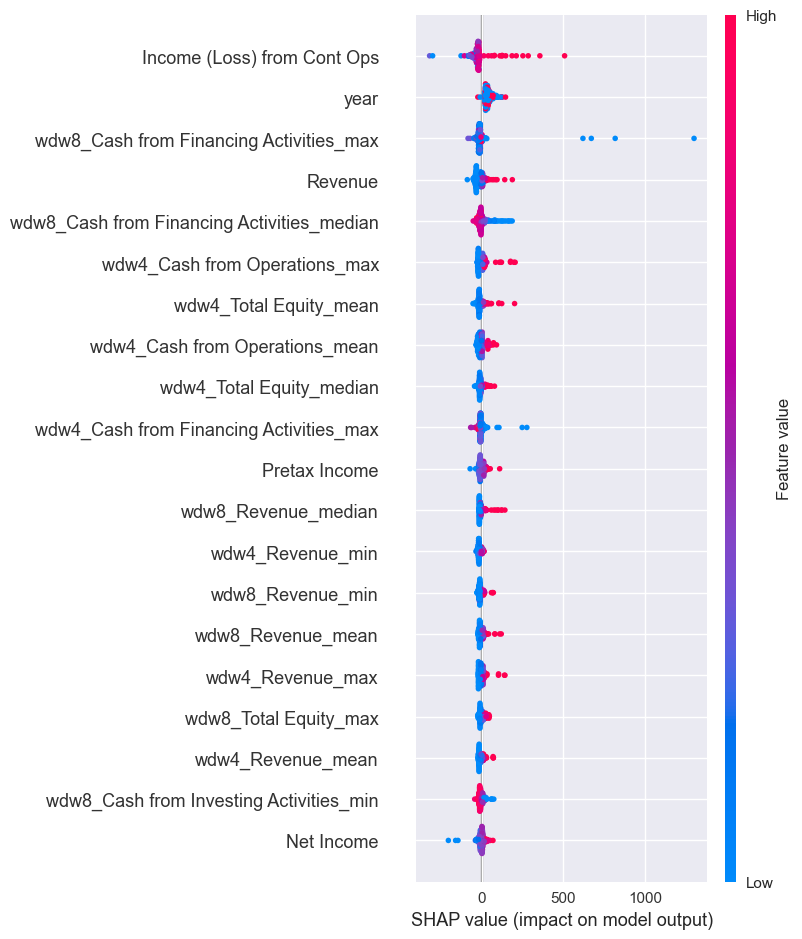

In [34]:
shap.summary_plot(shap_values[:,:-1], X_test_features)

P. S. wnw{n} - означает, что показатель рассчитывался по n последним кварталам. Например, wnw8_Cash from Investing Activities_median означает среднее значение Cash from Investing Activities за последние 8 кварталов, то есть за последние 2 года.